In [1]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt

from data import pipeline
from data.window import SlidingWindow

# Data preparation

In [2]:
X_train, Y_train, X_test, Y_test = pipeline.load("LSTM") # load / buildAndSave / build

Loading LSTM dataset
Done!


In [3]:
print(X_train.shape)
print(Y_train.shape)

(1027718, 4, 8)
(1027718, 1)


In [4]:
from sklearn.preprocessing import StandardScaler

X_train = X_train.reshape(-1, 32)
X_test = X_test.reshape(-1, 32)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = StandardScaler()
Y_train = sc_y.fit_transform(Y_train.reshape(-1, 1))
print(Y_train.shape)

(1027718, 1)


In [5]:
X_train = X_train.reshape(-1, 4, 8)
X_test = X_test.reshape(-1, 4, 8)

# Training

In [6]:
batch, window, features = X_train.shape

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(86, activation='relu', input_shape=(window, features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    
    # Tune the number of units in the LSTM per cell in the layer
    # hp_units between 50-100
    hp_units = hp.Int('units', min_value= 50, max_value= 100, step= 5)
    model.add(LSTM(units= hp_units, activation= 'relu', input_shape= (4, 8)))
    model.add(Dense(1))

    # Tune the learning rate for the optimizer
    # hp_learning_rate from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(optimizer= Adam(learning_rate= hp_learning_rate),
                  loss= ['mean_squared_error'],
                  metrics= [MeanSquaredError()])
    return model

# create model
tuner = kt.RandomSearch(
    hypermodel= build_model,
    objective= kt.Objective("val_mean_squared_error", direction= "min"),
    executions_per_trial= 2,
    project_name= "lstm_automl",
)

tuner.search(x= X_train, y= Y_train, epochs= 1, validation_split= 0.2) # epochs= 10

tuner.results_summary()

In [21]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The best dimension of the hidden state found is {best_hps.get('units')} and the best learning rate found is {best_hps.get('learning_rate')}.")

The best dimension of the hidden state found is 65 and the best learning rate found is 0.0001.


In [22]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs= 10, validation_split= 0.2)

In [23]:
val_acc_per_epoch = history.history['val_mean_squared_error']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 1


In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print('Train MSE : %.3f' % sqrt(mean_squared_error(Y_train, model.predict(X_train))))

32117/32117 [==============================] - 41s 1ms/step
Train MSE : 0.230


# Evaluation

In [30]:
X_test = X_test[:1000]

In [31]:
sw = SlidingWindow(X_test)

In [32]:
pred = model.predict(sw.values.reshape(-1, 4, 8), verbose=2)
Y_preds = [pred]

1/1 - 0s - 16ms/epoch - 16ms/step


In [33]:
last_progression = 0
print(0, '%')
while sw.next(pred): # iterator: t-1
    pred = model.predict(sw.values.reshape(-1, 4, 8), verbose=0) # iterator: t
    Y_preds.append(pred)
        
    progression = (sw.it+1) / len(X_test) * 100
    if progression - last_progression > 1 and not int(progression) % 10:
        print(int(progression), '%')
        last_progression = progression

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %


In [34]:
Y_preds = np.array(Y_preds)

In [35]:
Y_preds = sc_y.inverse_transform(Y_preds.reshape(1, -1))
Y_preds = Y_preds.reshape(-1)

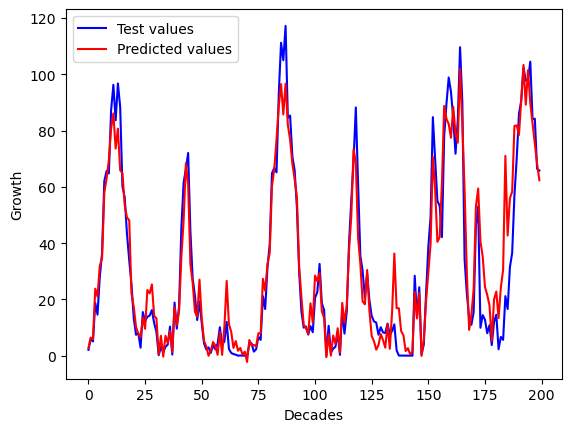

In [36]:
Y_preds = Y_preds.reshape(-1)
plt.plot(np.arange(len(Y_preds[:200])), Y_test[:200], color="blue", label= "Test values")
plt.plot(np.arange(len(Y_preds[:200])), Y_preds[:200], color="red", label= "Predicted values")
plt.xlabel("Decades")
plt.ylabel("Growth")
plt.legend()
plt.show()

In [37]:
print('Test MSE  : %.3f' % sqrt(mean_squared_error(Y_test[:1000], Y_preds)))

Test MSE  : 8.540
